In [21]:
import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



./input\linkedin\postings.csv
./input\linkedin\companies\companies.csv
./input\linkedin\companies\company_industries.csv
./input\linkedin\companies\company_specialities.csv
./input\linkedin\companies\employee_counts.csv
./input\linkedin\jobs\benefits.csv
./input\linkedin\jobs\job_industries.csv
./input\linkedin\jobs\job_skills.csv
./input\linkedin\jobs\salaries.csv
./input\linkedin\mappings\industries.csv
./input\linkedin\mappings\skills.csv
./input\resumes\data\data\ACCOUNTANT\10554236.pdf
./input\resumes\data\data\ACCOUNTANT\10674770.pdf
./input\resumes\data\data\ACCOUNTANT\11163645.pdf
./input\resumes\data\data\ACCOUNTANT\11759079.pdf
./input\resumes\data\data\ACCOUNTANT\12065211.pdf
./input\resumes\data\data\ACCOUNTANT\12202337.pdf
./input\resumes\data\data\ACCOUNTANT\12338274.pdf
./input\resumes\data\data\ACCOUNTANT\12442909.pdf
./input\resumes\data\data\ACCOUNTANT\12780508.pdf
./input\resumes\data\data\ACCOUNTANT\12802330.pdf
./input\resumes\data\data\ACCOUNTANT\13072019.pdf
./in

In [22]:
df = pd.read_csv('./input/resumes/Resume/Resume.csv')

In [23]:
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [24]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
import pandas as pd
from PyPDF2 import PdfReader
from nltk import pos_tag, sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
import re
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\LARAIB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LARAIB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\LARAIB\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [25]:
resume_data = pd.read_csv('./input/resumes/Resume/Resume.csv')
resume_data.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [26]:
resume_data.describe().T
resume_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


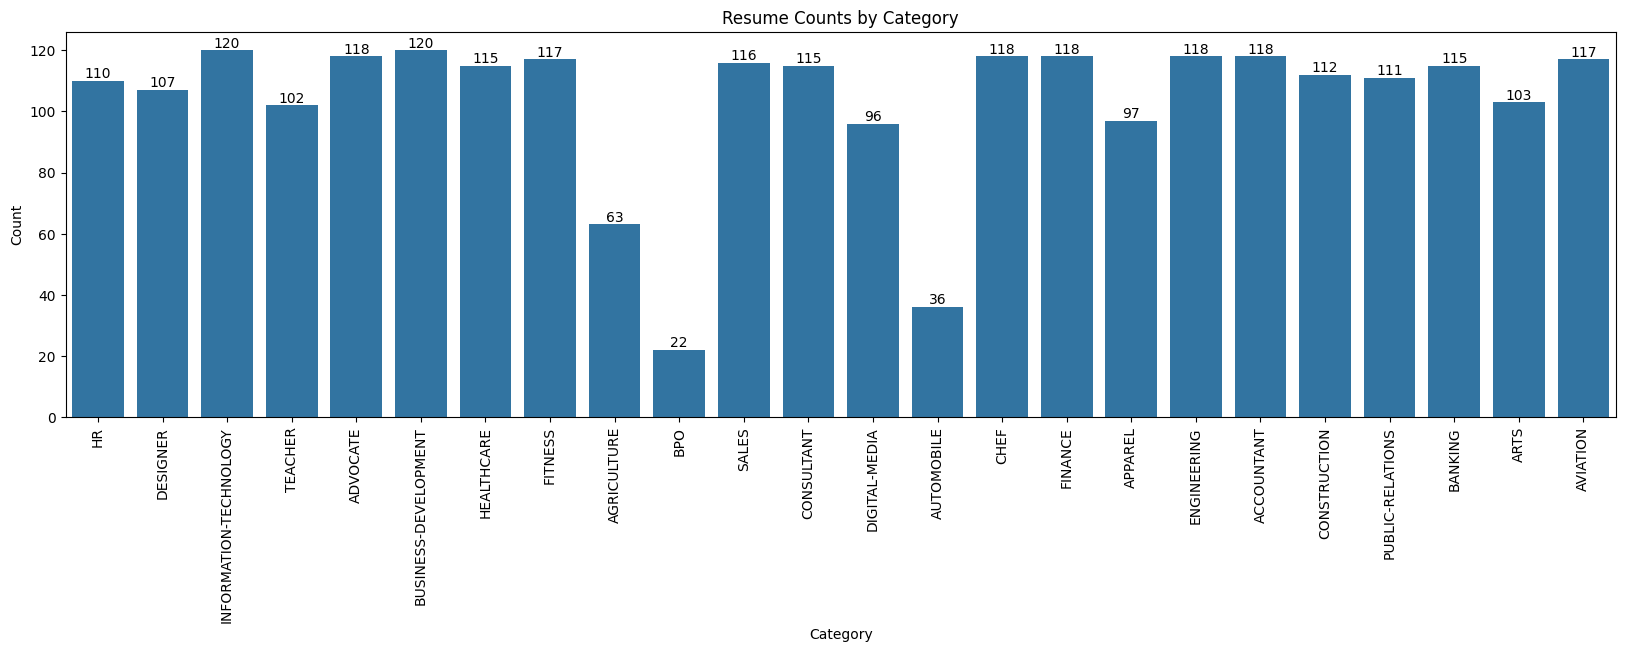

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 5))
plt.xticks(rotation=90)


ax = sns.countplot(x="Category", data=resume_data)


for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')


plt.title("Resume Counts by Category")
plt.ylabel("Count")
plt.xlabel("Category")

plt.show()

In [28]:
resume_data = resume_data.drop(["Resume_html"], axis=1)
resume_data.head()

,ID,Resume_str,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,33176873,HR DIRECTOR Summary Over 2...,HR
3,27018550,HR SPECIALIST Summary Dedica...,HR
4,17812897,HR MANAGER Skill Highlights ...,HR


In [29]:
def extract_text_from_pdf(file_path):
    reader = PdfReader(file_path)
    text = "".join(page.extract_text() for page in reader.pages)
    return text

In [30]:
def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    sentences = sent_tokenize(text)
    features = {'feature': ""}
    stop_words = set(stopwords.words("english"))
    for sent in sentences:
        if any(criteria in sent for criteria in ['skills', 'education']):
            words = word_tokenize(sent)
            words = [word for word in words if word not in stop_words]
            tagged_words = pos_tag(words)
            filtered_words = [word for word, tag in tagged_words if tag not in ['DT', 'IN', 'TO', 'PRP', 'WP']]
            features['feature'] += " ".join(filtered_words)
    return features

In [31]:
def process_resume_data(df):
    id = df['ID']
    category = df['Category']
    text = extract_text_from_pdf(f"./input/resumes/data/data/{category}/{id}.pdf")
    features = preprocess_text(text)
    df['Feature'] = features['feature']
    return df

In [32]:
def get_embeddings(text, model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    inputs = tokenizer(str(text), return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().to("cpu").numpy()
    return embeddings

In [33]:
def print_top_matching_resumes(result_group):
    for i in range(15):
        print("\nJob ID:", i)
        print("Cosine Similarity | Domain Resume | Domain Description")
        print(result_group.get_group(i)[['similarity', 'domainResume', 'domainDesc']])

In [34]:
resume_data.duplicated(subset=['Resume_str']).value_counts()

False    2482
True        2
Name: count, dtype: int64

In [35]:
resume_data = resume_data.drop_duplicates(subset=['Resume_str'], keep='first')
resume_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2482 entries, 0 to 2482
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          2482 non-null   int64 
 1   Resume_str  2482 non-null   object
 2   Category    2482 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.6+ KB


In [36]:
resume_data = resume_data.apply(process_resume_data, axis=1)
resume_data.head()

,ID,Resume_str,Category,Feature
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,hr administrator marketing associate hr admini...
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,hr specialist hr operations summary media prof...
2,33176873,HR DIRECTOR Summary Over 2...,HR,hr director summary years experience recruitin...
3,27018550,HR SPECIALIST Summary Dedica...,HR,hr specialist summary dedicated driven dynamic...
4,17812897,HR MANAGER Skill Highlights ...,HR,hr manager skill highlights hr skills hr depar...


In [37]:
resume_data = resume_data.drop(columns=['Resume_str'])
resume_data.head()

,ID,Category,Feature
0,16852973,HR,hr administrator marketing associate hr admini...
1,22323967,HR,hr specialist hr operations summary media prof...
2,33176873,HR,hr director summary years experience recruitin...
3,27018550,HR,hr specialist summary dedicated driven dynamic...
4,17812897,HR,hr manager skill highlights hr skills hr depar...


In [38]:
import nltk
from nltk.probability import FreqDist

# Get the most common words
def print_most_frequent_words(text, top_n=50):
    words = nltk.word_tokenize(text)
    wordfreqdist = FreqDist(words)
    mostcommon = wordfreqdist.most_common(top_n)
    for word, freq in mostcommon:
        print(f"{word}: {freq}")

combined_text = " ".join(resume_data['Feature'].astype(str))
print_most_frequent_words(combined_text)

state: 16057
company: 15205
city: 15062
management: 12163
name: 11723
sales: 8255
customer: 7918
business: 7862
skills: 7664
new: 6400
service: 6194
team: 6066
development: 5734
training: 5625
experience: 5608
project: 5373
work: 4790
manager: 4531
marketing: 4490
information: 4487
financial: 4217
office: 4177
support: 4124
education: 4057
including: 4051
staff: 3920
professional: 3851
data: 3788
system: 3700
systems: 3556
university: 3469
managed: 3424
process: 3416
customers: 3388
design: 3385
quality: 3350
client: 3270
clients: 3241
developed: 3225
reports: 3086
analysis: 3041
operations: 3001
high: 2950
product: 2948
program: 2934
services: 2832
microsoft: 2826
accounting: 2822
current: 2783
accounts: 2775


In [39]:
company_industries = pd.read_csv("./input/linkedin/companies/company_industries.csv")
company_industries.head()

,company_id,industry
0,391906,Book and Periodical Publishing
1,22292832,Construction
2,20300,Banking
3,3570660,Book and Periodical Publishing
4,878353,Staffing and Recruiting


In [40]:
company_industries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24375 entries, 0 to 24374
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   company_id  24375 non-null  int64 
 1   industry    24375 non-null  object
dtypes: int64(1), object(1)
memory usage: 381.0+ KB


In [41]:
desired_industries = ["IT Services and IT Consulting", "Financial Services", "Real Estate", "Banking"]

In [42]:
filtered_industries = company_industries[company_industries['industry'].isin(desired_industries)]
filtered_industries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3881 entries, 2 to 24371
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   company_id  3881 non-null   int64 
 1   industry    3881 non-null   object
dtypes: int64(1), object(1)
memory usage: 91.0+ KB


In [44]:
job_posts = pd.read_csv('./input/linkedin/postings.csv')
job_posts.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


In [45]:
job_posts = job_posts[["job_id","company_id","company_name","title","description","skills_desc"]]
job_posts.head()

,job_id,company_id,company_name,title,description,skills_desc
0,921716,2774458.0,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,Requirements: \n\nWe are seeking a College or ...
1,1829192,NaN,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",NaN
2,10998357,64896719.0,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,We are currently accepting resumes for FOH - A...
3,23221523,766262.0,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,This position requires a baseline understandin...
4,35982263,NaN,NaN,Service Technician,Looking for HVAC service tech with experience ...,NaN


In [48]:
print(job_posts["skills_desc"][12])

Skills/Qualifications: Two-year or four-year degree in business or marketing and 0—2 years of previous experience. Position requires outstanding verbal skills and the ability to handle multiple tasks. Must be proficient in Microsoft Word, Outlook, Excel, Power Point, and Constant Contact. Social media knowledge and some graphic design skills would be a definite advantage. 


In [49]:
job_descriptions = job_posts[["description","skills_desc","title","company_id"]]
job_descriptions.head()

,description,skills_desc,title,company_id
0,Job descriptionA leading real estate firm in N...,Requirements: \n\nWe are seeking a College or ...,Marketing Coordinator,2774458.0
1,"At Aspen Therapy and Wellness , we are committ...",NaN,Mental Health Therapist/Counselor,NaN
2,The National Exemplar is accepting application...,We are currently accepting resumes for FOH - A...,Assitant Restaurant Manager,64896719.0
3,Senior Associate Attorney - Elder Law / Trusts...,This position requires a baseline understandin...,Senior Elder Law / Trusts and Estates Associat...,766262.0
4,Looking for HVAC service tech with experience ...,NaN,Service Technician,NaN


In [50]:
job_descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   description  123842 non-null  object 
 1   skills_desc  2439 non-null    object 
 2   title        123849 non-null  object 
 3   company_id   122132 non-null  float64
dtypes: float64(1), object(3)
memory usage: 3.8+ MB


In [51]:
job_descriptions.isnull().sum()

description         7
skills_desc    121410
title               0
company_id       1717
dtype: int64

In [52]:
job_descriptions = job_descriptions.dropna()
job_descriptions.isnull().sum()

description    0
skills_desc    0
title          0
company_id     0
dtype: int64

C:\Users\LARAIB\AppData\Local\Temp\ipykernel_19144\3871294545.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


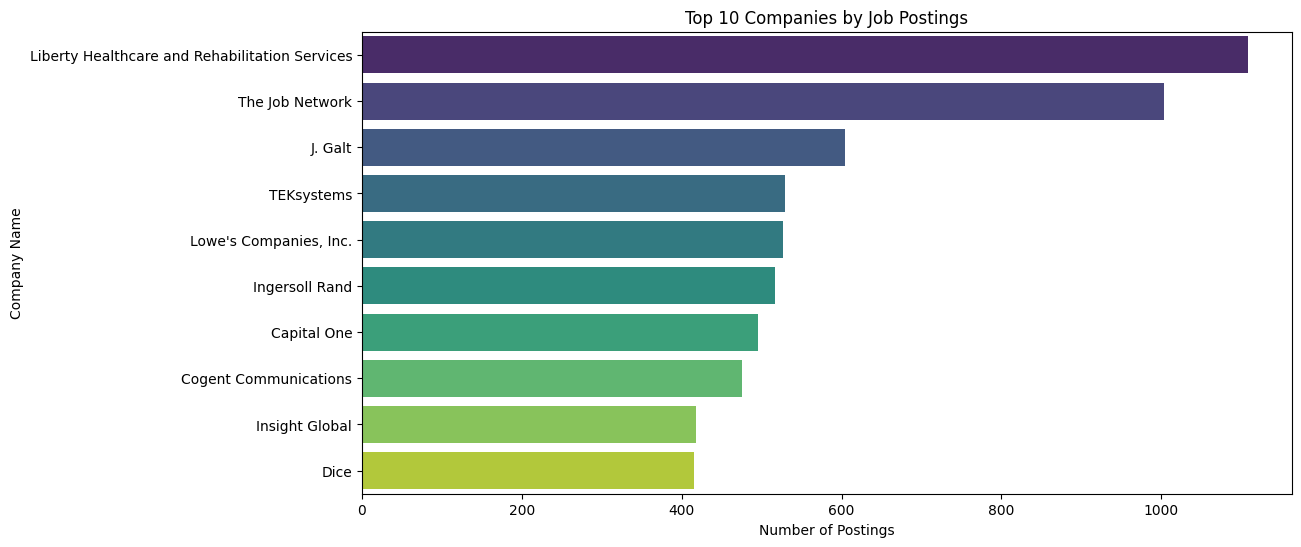

In [53]:
plt.figure(figsize=(12, 6))
sns.countplot(
    y='company_name',
    data=job_posts,
    order=job_posts['company_name'].value_counts().index[:10],
    palette='viridis'
)
plt.title('Top 10 Companies by Job Postings')
plt.xlabel('Number of Postings')
plt.ylabel('Company Name')
plt.show()

In [54]:
job_descriptions_filtered = job_descriptions.merge(filtered_industries[['company_id']], on='company_id', how='inner')

In [55]:
job_descriptions_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  385 non-null    object 
 1   skills_desc  385 non-null    object 
 2   title        385 non-null    object 
 3   company_id   385 non-null    float64
dtypes: float64(1), object(3)
memory usage: 12.2+ KB


In [56]:
job_descriptions_filtered.head()

,description,skills_desc,title,company_id
0,Job descriptionA leading real estate firm in N...,Requirements: \n\nWe are seeking a College or ...,Marketing Coordinator,2774458.0
1,WORK @ SWShannon Waltchack (SW) is seeking a C...,Strong interpersonal communication skills and ...,Controller,988555.0
2,Software Tester - State Government or Public S...,"SYSTEM TESTING , MICROSOFT OFFICE , SOFTWARE D...",Software Tester,95750606.0
3,About the Role:\n\nAs a CBRE Legal Data Analys...,What You’ll Need: \n\n * Applicants must be cu...,Legal Data Analyst (Dallas/Chicago),2319.0
4,Description:\nAvesta Housing is seeking a hard...,Ability to meet facility and state immunizatio...,Cook,1182899.0


In [57]:
job_descriptions2 = job_descriptions_filtered.dropna()
job_descriptions2.head()
job_descriptions2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  385 non-null    object 
 1   skills_desc  385 non-null    object 
 2   title        385 non-null    object 
 3   company_id   385 non-null    float64
dtypes: float64(1), object(3)
memory usage: 12.2+ KB


In [58]:
print(job_descriptions2['description'].apply(type).value_counts())

description
<class 'str'>    385
Name: count, dtype: int64


In [59]:
job_descriptions2 = job_descriptions2[job_descriptions2['description'].apply(lambda x: isinstance(x, str))]

In [60]:

def preprocess(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    sentences = sent_tokenize(text)
    features = {'feature': ""}
    stop_words = set(stopwords.words("english"))
    for sent in sentences:
        # Tokenize, remove stopwords, and filter by POS tags
        words = word_tokenize(sent)
        words = [word for word in words if word not in stop_words]
        tagged_words = pos_tag(words)
        filtered_words = [word for word, tag in tagged_words if tag not in ['DT', 'IN', 'TO', 'PRP', 'WP']]
        features['feature'] += " ".join(filtered_words) + " "
    return features

In [61]:
job_descriptions2['jdFeatures'] = job_descriptions2['description'].apply(lambda x : preprocess_text(x)['feature'])
job_descriptions2['skillFeatures'] = job_descriptions2['skills_desc'].apply(lambda x : preprocess_text(x)['feature'])
job_descriptions2.head()

,description,skills_desc,title,company_id,jdFeatures,skillFeatures
0,Job descriptionA leading real estate firm in N...,Requirements: \n\nWe are seeking a College or ...,Marketing Coordinator,2774458.0,job descriptiona leading real estate firm new ...,
1,WORK @ SWShannon Waltchack (SW) is seeking a C...,Strong interpersonal communication skills and ...,Controller,988555.0,work swshannon waltchack sw seeking commercial...,strong interpersonal communication skills stro...
2,Software Tester - State Government or Public S...,"SYSTEM TESTING , MICROSOFT OFFICE , SOFTWARE D...",Software Tester,95750606.0,,
3,About the Role:\n\nAs a CBRE Legal Data Analys...,What You’ll Need: \n\n * Applicants must be cu...,Legal Data Analyst (Dallas/Chicago),2319.0,,need applicants must currently authorized work...
4,Description:\nAvesta Housing is seeking a hard...,Ability to meet facility and state immunizatio...,Cook,1182899.0,description avesta housing seeking hard workin...,ability meet facility state immunization requi...


In [62]:
job_descriptions2['jdFeatures'] = job_descriptions2['jdFeatures'].replace(r'^\s*$', np.nan, regex=True)
job_descriptions2['skillFeatures'] = job_descriptions2['skillFeatures'].replace(r'^\s*$', np.nan, regex=True)
job_descriptions2.head()

,description,skills_desc,title,company_id,jdFeatures,skillFeatures
0,Job descriptionA leading real estate firm in N...,Requirements: \n\nWe are seeking a College or ...,Marketing Coordinator,2774458.0,job descriptiona leading real estate firm new ...,NaN
1,WORK @ SWShannon Waltchack (SW) is seeking a C...,Strong interpersonal communication skills and ...,Controller,988555.0,work swshannon waltchack sw seeking commercial...,strong interpersonal communication skills stro...
2,Software Tester - State Government or Public S...,"SYSTEM TESTING , MICROSOFT OFFICE , SOFTWARE D...",Software Tester,95750606.0,NaN,NaN
3,About the Role:\n\nAs a CBRE Legal Data Analys...,What You’ll Need: \n\n * Applicants must be cu...,Legal Data Analyst (Dallas/Chicago),2319.0,NaN,need applicants must currently authorized work...
4,Description:\nAvesta Housing is seeking a hard...,Ability to meet facility and state immunizatio...,Cook,1182899.0,description avesta housing seeking hard workin...,ability meet facility state immunization requi...


In [63]:
job_descriptions2.isnull().sum()

description        0
skills_desc        0
title              0
company_id         0
jdFeatures       116
skillFeatures    357
dtype: int64

In [64]:
job_descriptions2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   description    385 non-null    object 
 1   skills_desc    385 non-null    object 
 2   title          385 non-null    object 
 3   company_id     385 non-null    float64
 4   jdFeatures     269 non-null    object 
 5   skillFeatures  28 non-null     object 
dtypes: float64(1), object(5)
memory usage: 18.2+ KB


In [65]:
job_descriptions2 = job_descriptions2.drop(columns=["skills_desc","skillFeatures"],axis=1)
job_descriptions2.head()

,description,title,company_id,jdFeatures
0,Job descriptionA leading real estate firm in N...,Marketing Coordinator,2774458.0,job descriptiona leading real estate firm new ...
1,WORK @ SWShannon Waltchack (SW) is seeking a C...,Controller,988555.0,work swshannon waltchack sw seeking commercial...
2,Software Tester - State Government or Public S...,Software Tester,95750606.0,NaN
3,About the Role:\n\nAs a CBRE Legal Data Analys...,Legal Data Analyst (Dallas/Chicago),2319.0,NaN
4,Description:\nAvesta Housing is seeking a hard...,Cook,1182899.0,description avesta housing seeking hard workin...


In [66]:
job_descriptions2 = job_descriptions2.dropna(subset=['jdFeatures'])
job_descriptions2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 269 entries, 0 to 384
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  269 non-null    object 
 1   title        269 non-null    object 
 2   company_id   269 non-null    float64
 3   jdFeatures   269 non-null    object 
dtypes: float64(1), object(3)
memory usage: 10.5+ KB


TF-IDF


In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer


corpus = list(resume_data['Feature']) + list(job_descriptions2['jdFeatures'])


vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(corpus)

# Split the TF-IDF matrix into resumes and job descriptions
resume_tfidf = tfidf_matrix[:len(resume_data)]
job_tfidf = tfidf_matrix[len(resume_data):]

In [68]:
print(resume_tfidf)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 750239 stored elements and shape (2482, 5000)>
  Coords	Values
  (0, 2138)	0.11978221941210322
  (0, 129)	0.1247345583221593
  (0, 2715)	0.2575524459050627
  (0, 339)	0.06207683973920197
  (0, 4469)	0.012561592880712413
  (0, 1194)	0.028552158912524127
  (0, 1107)	0.17802961565715622
  (0, 4100)	0.12103360799731572
  (0, 2675)	0.05893280786964398
  (0, 4992)	0.015779841963488583
  (0, 1692)	0.019272101517763648
  (0, 2122)	0.08196833777859301
  (0, 2643)	0.06646552302997759
  (0, 529)	0.04358309020157073
  (0, 2483)	0.024810728294115406
  (0, 1861)	0.05131698738059375
  (0, 4563)	0.022468580792042534
  (0, 4138)	0.038551563473459664
  (0, 1575)	0.0348185999586065
  (0, 799)	0.03771842793454506
  (0, 2089)	0.0178845543259155
  (0, 3993)	0.024756874148805178
  (0, 4551)	0.01211608268537472
  (0, 3998)	0.040580980905492454
  (0, 910)	0.033084092595709824
  :	:
  (2481, 392)	0.034891882547011595
  (2481, 1275)	0.0449852815413422

In [69]:
from sklearn.metrics.pairwise import cosine_similarity

tfidf_similarity_matrix = cosine_similarity(job_tfidf, resume_tfidf)

# Get top 5 resumes for each job description
for job_idx in range(5,15):
    top_resumes = tfidf_similarity_matrix[job_idx].argsort()[::-1][:5]
    print(f"Job: {job_descriptions2['title'].iloc[job_idx]}")
    for idx in top_resumes:
        print(f"  Resume ID: {resume_data['ID'].iloc[idx]}, Similarity: {tfidf_similarity_matrix[job_idx][idx]:.4f}")

Job: Oracle HCM Cloud Architect
  Resume ID: 21366189, Similarity: 0.3637
  Resume ID: 93349646, Similarity: 0.3474
  Resume ID: 13454871, Similarity: 0.2942
  Resume ID: 18159866, Similarity: 0.2765
  Resume ID: 33381211, Similarity: 0.2546
Job: SAP ISU ABAP, CDS view, AMDP, C4C
  Resume ID: 93459677, Similarity: 0.2303
  Resume ID: 56068028, Similarity: 0.1728
  Resume ID: 38535335, Similarity: 0.1606
  Resume ID: 23527321, Similarity: 0.1577
  Resume ID: 22259768, Similarity: 0.1521
Job: AS400 Developer
  Resume ID: 99124477, Similarity: 0.2694
  Resume ID: 13520837, Similarity: 0.2455
  Resume ID: 18297650, Similarity: 0.2055
  Resume ID: 85101052, Similarity: 0.1620
  Resume ID: 19053815, Similarity: 0.1368
Job: Windows Architect
  Resume ID: 27058381, Similarity: 0.4382
  Resume ID: 15145575, Similarity: 0.4153
  Resume ID: 12043694, Similarity: 0.3502
  Resume ID: 10089434, Similarity: 0.3463
  Resume ID: 33627938, Similarity: 0.3421
Job: Developer
  Resume ID: 28505854, Similar

In [70]:
check_orig_resume = pd.read_csv('./input/resumes/Resume/Resume.csv')
check_orig_resume.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [71]:
print("Job: Engineering Project Manager | Similarity: 0.3897")
resume_row = check_orig_resume[check_orig_resume['ID'] == 28697203]
print()
print(resume_row['Resume_str'].iloc[0])

Job: Engineering Project Manager | Similarity: 0.3897

        AS         INFORMATION TECHNOLOGY PROJECT MANAGER       Summary    SUMMARY Skilled IT professional with 7 years of proven success in developing and leading cross-functional
technical teams to execute and deliver major technology initiatives using the Agile methodology and
Scaled Agile Framework (SAFe). Well-versed in managing projects with co-located and off-site teams.
Expertise in gathering and translating requirements, leading scrum teams, and release management,
including owning the release management lifecycle for multiple applications across different
environments.      Skills          Agile methodology  Project management  SAFe Program Increment (PI) Planning  Scrum / Kanban / Scrumban  Aptitude for resolving challenging problems  Client relations  Team building  Release management  Scrum master / Business analyst  Atlassian suite (JIRA, Confluence, Trello)  Public Trust Clearance Level 4  Agile  Approach      Budget

In [72]:
resume_row

,ID,Resume_str,Resume_html,Category
268,28697203,AS INFORMATION TECHNOLOGY PROJ...,"<div class=""RNA skn-mng3 fontsize fontface vma...",INFORMATION-TECHNOLOGY


LDA


In [73]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Step 1: Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
all_text = list(resume_data['Feature']) + list(job_descriptions2['jdFeatures'])
vectorized_text = vectorizer.fit_transform(all_text)

# Step 2: Fit LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42)  # Assuming 3 topics for simplicity
lda_matrix = lda.fit_transform(vectorized_text)

# Step 3: Separate LDA outputs for resumes and job descriptions
resume_topics = lda_matrix[:len(resume_data)]
job_topics = lda_matrix[len(resume_data):]

# Step 4: Compute cosine similarity
lda_similarity_matrix = cosine_similarity(job_topics, resume_topics)

# Step 5: Find top matches for each job description
top_matches = {}
for job_idx in range(5,15):
    top_resumes = lda_similarity_matrix[job_idx].argsort()[::-1][:5]  # Top 5 matches
    top_matches[job_descriptions2['title'].iloc[job_idx]] = [
        (resume_data['ID'].iloc[resume_idx], lda_similarity_matrix[job_idx, resume_idx])
        for resume_idx in top_resumes
    ]

# Display the results
for job, matches in top_matches.items():
    print(f"Job Title: {job}")
    for resume_id, score in matches:
        print(f"  Resume ID: {resume_id}, Similarity Score: {score:.4f}")

Job Title: Oracle HCM Cloud Architect
  Resume ID: 24708621, Similarity Score: 0.9958
  Resume ID: 13405733, Similarity Score: 0.9950
  Resume ID: 26896699, Similarity Score: 0.9949
  Resume ID: 33381211, Similarity Score: 0.9947
  Resume ID: 37521676, Similarity Score: 0.9944
Job Title: SAP ISU ABAP, CDS view, AMDP, C4C
  Resume ID: 50328713, Similarity Score: 0.9770
  Resume ID: 17987433, Similarity Score: 0.9645
  Resume ID: 10567764, Similarity Score: 0.9083
  Resume ID: 14049846, Similarity Score: 0.8446
  Resume ID: 82125182, Similarity Score: 0.8391
Job Title: AS400 Developer
  Resume ID: 10945968, Similarity Score: 0.9069
  Resume ID: 41651672, Similarity Score: 0.8180
  Resume ID: 29647215, Similarity Score: 0.7711
  Resume ID: 10501991, Similarity Score: 0.7706
  Resume ID: 75297735, Similarity Score: 0.7698
Job Title: Windows Architect
  Resume ID: 25959103, Similarity Score: 0.9851
  Resume ID: 22622351, Similarity Score: 0.9836
  Resume ID: 19362586, Similarity Score: 0.98

In [74]:
# Display top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 10)

Topic 0:
management state company city employee hr care health human training
Topic 1:
financial accounting company management state city accounts reports support analysis
Topic 2:
customer service state company city sales customers skills food team
Topic 3:
marketing company city state media public relations sales design events
Topic 4:
claims medical coding insurance customer team billing experience ibm service
Topic 5:
project construction engineering city state design company work equipment projects
Topic 6:
business management sales development company project new team state city
Topic 7:
experience ability work required skills knowledge position time role requirements
Topic 8:
training state management city aviation systems aircraft personnel maintenance company
Topic 9:
students state city student education school teacher company learning skills


Word2Vec


In [76]:
import gensim
from gensim.models import Word2Vec


# Tokenize the resumes and job descriptions
tokenized_corpus = [text.split() for text in resume_data['Feature']] + [text.split() for text in job_descriptions2['jdFeatures']]

#Train word2Vec model
model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

model.save("resume_word2vec.model")

In [77]:
def document_embedding(text, model):
    tokens = text.split()  # Tokenize the text
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)  # Mean of all word embeddings
    else:
        return np.zeros(model.vector_size)  # Return zero vector if no embeddings

In [78]:
resume_embeddings = np.array([document_embedding(text, model) for text in resume_data['Feature']])
job_description_embeddings = np.array([document_embedding(text, model) for text in job_descriptions2['jdFeatures']])

In [79]:
#Similarity Analysis with Word2Vec

from sklearn.metrics.pairwise import cosine_similarity

w2v_similarity_matrix = cosine_similarity(job_description_embeddings, resume_embeddings)

# Get top 5 resumes for each job description
for job_idx in range(5,15):
    top_resumes = w2v_similarity_matrix[job_idx].argsort()[::-1][:5]
    print(f"Job: {job_descriptions2['title'].iloc[job_idx]}")
    for idx in top_resumes:
        print(f"  Resume ID: {resume_data['ID'].iloc[idx]}, Similarity: {w2v_similarity_matrix[job_idx][idx]:.4f}")

Job: Oracle HCM Cloud Architect
  Resume ID: 13964744, Similarity: 0.9452
  Resume ID: 60489316, Similarity: 0.9288
  Resume ID: 11813872, Similarity: 0.9268
  Resume ID: 28126340, Similarity: 0.9212
  Resume ID: 29134721, Similarity: 0.9201
Job: SAP ISU ABAP, CDS view, AMDP, C4C
  Resume ID: 25207620, Similarity: 0.8931
  Resume ID: 29134721, Similarity: 0.8568
  Resume ID: 57364820, Similarity: 0.8442
  Resume ID: 27152464, Similarity: 0.8441
  Resume ID: 62994611, Similarity: 0.8440
Job: AS400 Developer
  Resume ID: 29134721, Similarity: 0.8862
  Resume ID: 78016758, Similarity: 0.8847
  Resume ID: 25207620, Similarity: 0.8796
  Resume ID: 32965335, Similarity: 0.8734
  Resume ID: 21038022, Similarity: 0.8689
Job: Windows Architect
  Resume ID: 10089434, Similarity: 0.9522
  Resume ID: 17641670, Similarity: 0.9309
  Resume ID: 14593060, Similarity: 0.9281
  Resume ID: 27058381, Similarity: 0.9275
  Resume ID: 44115326, Similarity: 0.9262
Job: Developer
  Resume ID: 29087505, Similar

In [80]:
print("Job: Manager, Data Analytics | Best Match: 0.9493")
resume_row1 = check_orig_resume[check_orig_resume['ID'] == 11813872]
print()
print(resume_row1['Resume_str'].iloc[0])

Job: Manager, Data Analytics | Best Match: 0.9493

         VP, PRINCIPAL       Summary     I am highly skilled,growth mindset IT professional having more than 20 years experience mostly in financial industry related with providing advanced data solutions using innovative database technology. Very innovative,creative, great problem solver and have achieved the highest ratings consistently for more than 10 years. Continuously learning,adapting and evolving by overcoming challenges faced during professional career. I am fortunate to be a part of team who has delivered cutting edge products over the years to help our firm and clients. My career philosophy is  4LT(Listen,Learn,Love,Lead and earn Trust).        Skills          Deep expertise in designing,developing, implementing and running mission critical systems involving OLTP,OLAP and HTAP workloads  Extensive experience in building and deploying large scale applications in cloud environment(AWS)  Deep expertise in advanced data modelin

Comparison


In [81]:
print("TF-IDF Similarity Matrix Shape:", tfidf_similarity_matrix.shape)
print("LDA Similarity Matrix Shape:", lda_similarity_matrix.shape)
print("Word2Vec Similarity Matrix Shape:", w2v_similarity_matrix.shape)
print("\nNumber of Resumes:", len(resume_data))
print("Number of Job Descriptions:", len(job_descriptions2))

TF-IDF Similarity Matrix Shape: (269, 2482)
LDA Similarity Matrix Shape: (269, 2482)
Word2Vec Similarity Matrix Shape: (269, 2482)

Number of Resumes: 2482
Number of Job Descriptions: 269


In [82]:
# Top 5 matches for each method
for method, similarity_matrix in zip(['TF-IDF', 'LDA', 'Word2Vec'], [tfidf_similarity_matrix, lda_similarity_matrix, w2v_similarity_matrix]):
    print(f"\nTop 5 matches using {method}:\n")
    for job_idx in range(5,8):
        top_resumes = similarity_matrix[job_idx].argsort()[::-1][:5]
        print(f"  Job: {job_descriptions2['title'].iloc[job_idx]}")
        for idx in top_resumes:
            print(f"    Resume ID: {resume_data['ID'].iloc[idx]}, Similarity: {similarity_matrix[job_idx][idx]:.4f}")


Top 5 matches using TF-IDF:

  Job: Oracle HCM Cloud Architect
    Resume ID: 21366189, Similarity: 0.3637
    Resume ID: 93349646, Similarity: 0.3474
    Resume ID: 13454871, Similarity: 0.2942
    Resume ID: 18159866, Similarity: 0.2765
    Resume ID: 33381211, Similarity: 0.2546
  Job: SAP ISU ABAP, CDS view, AMDP, C4C
    Resume ID: 93459677, Similarity: 0.2303
    Resume ID: 56068028, Similarity: 0.1728
    Resume ID: 38535335, Similarity: 0.1606
    Resume ID: 23527321, Similarity: 0.1577
    Resume ID: 22259768, Similarity: 0.1521
  Job: AS400 Developer
    Resume ID: 99124477, Similarity: 0.2694
    Resume ID: 13520837, Similarity: 0.2455
    Resume ID: 18297650, Similarity: 0.2055
    Resume ID: 85101052, Similarity: 0.1620
    Resume ID: 19053815, Similarity: 0.1368

Top 5 matches using LDA:

  Job: Oracle HCM Cloud Architect
    Resume ID: 24708621, Similarity: 0.9958
    Resume ID: 13405733, Similarity: 0.9950
    Resume ID: 26896699, Similarity: 0.9949
    Resume ID: 3338

In [83]:
orcl_resume_tfidf = check_orig_resume[check_orig_resume['ID'] == 21366189]
orcl_resume_lda = check_orig_resume[check_orig_resume['ID'] == 24708621]
orcl_resume_w2v = check_orig_resume[check_orig_resume['ID'] == 13964744]
print()
print(orcl_resume_tfidf['Resume_str'].iloc[0])


         CONSULTANT         Qualifications          I am a senior IT infrastructure specialist and have 7 years of OEM administration and 6 years of DBA administration. I have Masters in Computer Applications (MCA) and a seasoned technical specialist providing business infrastructure solutions, services and support, according to defined processes. With an overall experience spanning 12 years and having worked for Oracle for a period of 11 years, I have a tremendous track record in IT support area for multiple products and applications with a great level of consistency and excellence. My expertise includes,  His expertise includes,  Project Management  Oracle Enterprise Manager  Implementation Specialist	*WebLogic Server Administration  Incident Management  Database administration	*Oracle Cloud operations  People Management  ITIL Service Management  Operations Management  Change Management	*AWS  Process capability  Technical support for 24X7 systems              Technical Skills       

In [84]:
print(orcl_resume_lda['Resume_str'].iloc[0])

         PROCUREMENT ANALYST               Accomplishments      New Professional Organization Attend seminars and events relevant in today's business market.  Karass Effective Negotiating Training to develop key negotiating skills Six Sigma Yellow Belt Certification.        Professional Experience      Company Name     March 2012   to   Current     Procurement Analyst   City  ,   State      Performs strategic sourcing of MRO (Maintenance, Repairs, and Operations) items for the company's North American manufacturing locations as well as supplier management of the strategic suppliers - spend $70M+ Sourcing functions include contract strategy development, issuance of contract RFQs and RFPs, supplier proposal analysis, negotiations, awards and implementations.  Responsible for all supplier performance and the on-going management of strategic supplier relationships.  Creates integrated processes among internal functions (e.g., operations, purchasing and logistics) and outside suppliers.  Su

In [85]:
print(orcl_resume_w2v['Resume_str'].iloc[0])

         TEAM LEAD SENIOR ANALYST         Professional Summary     MBA in Business Management, Finance & M.S in Information technology Professional Summary: Overall 7+ years of experience in implementing and supporting Information technology operations and multiple business projects for Google Maps, Wipro for client Hewlett Packard. Over 4 years of experience in project management / operations management in leading multiple small scale and large projects by staffing and resource planning, managing metrics, people management, project life cycle. Managing day to day operations and KPI for the project and delivering in specific time frame. Determine and analyze process requirements and develop functional needs for the processes. Worked with cross functional teams for 5 years includes training, technical, quality, metadata, tech-stop and other cross functional teams like business analysts, quality analysts, Worked with other functional leads and senior / quality analysts by proposing vario

In [86]:
def average_top_k_similarity(similarity_matrix, k=5):
    # Ensure the matrix is dense
    if hasattr(similarity_matrix, "toarray"):
        similarity_matrix = similarity_matrix.toarray()

    top_k_scores = []
    for job_idx in range(similarity_matrix.shape[0]):
        # Get the row and ensure it's 1D
        row = similarity_matrix[job_idx]
        if row.ndim > 1:  # If it's not 1D, flatten it
            row = row.flatten()
        top_k = np.sort(row)[-k:]  # Top K scores
        top_k_scores.append(top_k.mean())
    return np.mean(top_k_scores)


tfidf_avg = average_top_k_similarity(tfidf_similarity_matrix, k=5)
lda_avg = average_top_k_similarity(lda_similarity_matrix, k=5)
word2vec_avg = average_top_k_similarity(w2v_similarity_matrix, k=5)

print(f"Average Top 5 Similarity Scores:")
print(f"  TF-IDF: {tfidf_avg:.4f}")
print(f"  LDA: {lda_avg:.4f}")
print(f"  Word2Vec: {word2vec_avg:.4f}")

Average Top 5 Similarity Scores:
  TF-IDF: 0.2524
  LDA: 0.9154
  Word2Vec: 0.9126


C:\Users\LARAIB\AppData\Local\Temp\ipykernel_19144\2943975558.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=df_scores, x="Method", y="Average Similarity", palette="viridis")


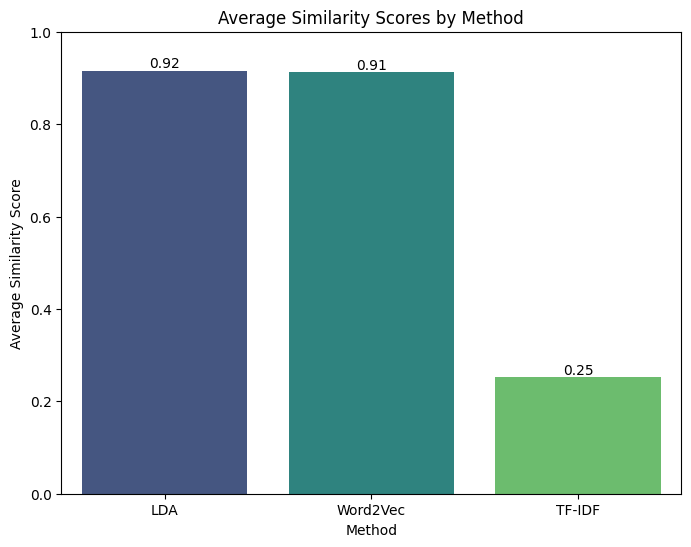

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example similarity scores (replace with actual values)
similarity_scores = {"TF-IDF": tfidf_avg, "LDA": lda_avg,"Word2Vec": word2vec_avg}
# Create a DataFrame for visualization
df_scores = pd.DataFrame(
    similarity_scores.items(),
    columns=["Method", "Average Similarity"]
)

# Sort scores in descending order for better visualization
df_scores = df_scores.sort_values(by="Average Similarity", ascending=False)

# Plotting using seaborn
plt.figure(figsize=(8, 6))
barplot = sns.barplot(data=df_scores, x="Method", y="Average Similarity", palette="viridis")

# Add value labels on top of bars
for bar in barplot.patches:
    barplot.annotate(
        format(bar.get_height(), '.2f'),  # Format the height value to 2 decimal places
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position at top of bar
        ha='center', va='bottom', fontsize=10, color='black'  # Styling
    )
    
plt.title("Average Similarity Scores by Method", fontsize=12)
plt.ylabel("Average Similarity Score", fontsize=10)
plt.xlabel("Method", fontsize=10)
plt.ylim(0, 1)  # Cosine similarity typically ranges from 0 to 1
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

TF-IDF:
Best for exact keyword matching.
Useful when job descriptions have strict, domain-specific terms

LDA:
Best for thematic analysis.
Useful when you want to match resumes based on general topics

Word2Vec:
Best for semantic understanding.
Useful when resumes and job descriptions use diverse but related terminology


In [90]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define similarity threshold and top K resumes per job description
SIMILARITY_THRESHOLD = 0.8
TOP_K = 10

# Precompute top K matches for efficiency
top_indices = np.argsort(similarity_matrix, axis=1)[:, -TOP_K:]  # Indices of top K resumes for each job

# Prepare features and labels dynamically
X = []
y = []

for job_idx, resume_indices in enumerate(top_indices):
    for resume_idx in resume_indices:
        combined_features = np.hstack([
            job_description_embeddings[job_idx],  # Job embedding
            resume_embeddings[resume_idx]         # Resume embedding
        ])
        X.append(combined_features)  # Add combined features
        y.append(1 if similarity_matrix[job_idx, resume_idx] > SIMILARITY_THRESHOLD else 0)  # Label based on threshold

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Validate shapes
print("Feature matrix shape (X):", X.shape)
print("Label vector shape (y):", y.shape)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

Feature matrix shape (X): (2690, 200)
Label vector shape (y): (2690,)
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00       534

    accuracy                           1.00       538
   macro avg       1.00      0.88      0.93       538
weighted avg       1.00      1.00      1.00       538



In [91]:
#Copying the function here for ease in verification

def preprocess_text1(text):
    import re
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize

    stop_words = set(stopwords.words("english"))
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())  # Remove non-alphabet characters
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)  # Ensure output is a string

In [92]:
# Example new data
new_resume = preprocess_text1("ighly skilled,growth mindset IT professional having more than 20 years experience mostly in financial industry related with providing advanced data solutions using innovative database technology. Very innovative,creative, great problem solver and have achieved the highest ratings consistently for more than 10 years. Continuously learning,adapting and evolving by overcoming challenges faced during professional career. I am fortunate to be a part of team who has delivered cutting edge products over the years to help our firm and clients. My career philosophy is  4LT(Listen,Learn,Love,Lead and earn Trust).        Skills          Deep expertise in designing,developing, implementing and running mission critical systems involving OLTP,OLAP and HTAP workloads  Extensive experience in building and deploying large scale applications in cloud environment(AWS)  Deep expertise in advanced data modeling, data management and data governance")
new_job_description = preprocess_text1("Looking for Data Scientist in financial industry related with providing advanced data solutions using innovative database technology. Ve")

# Convert text to embeddings
new_resume_embedding = np.mean(
    [model.wv[word] for word in new_resume.split() if word in model.wv], axis=0
)
new_job_description_embedding = np.mean(
    [model.wv[word] for word in new_job_description.split() if word in model.wv], axis=0
)

# Handle missing embeddings
new_resume_embedding = new_resume_embedding if new_resume_embedding is not None else np.zeros(model.vector_size)
new_job_description_embedding = new_job_description_embedding if new_job_description_embedding is not None else np.zeros(model.vector_size)

# Combine embeddings into features
test_features = np.hstack([new_job_description_embedding, new_resume_embedding])

# Predict using the trained model
prediction = clf.predict([test_features])
match_probability = clf.predict_proba([test_features])[0][1]
print("RESULT: \n")
# Output the result
if prediction[0] == 1:
    print(f"The resume is a good match for the job description with a probability of {match_probability:.2f}.")
else:
    print(f"The resume is not a good match for the job description with a probability of {match_probability:.2f}.")


RESULT: 

The resume is a good match for the job description with a probability of 0.76.


comparing model with chatgpt and other llms


In [93]:
import pandas as pd
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import re

# Step 1: Prepare Data
data = {
    "resume": [
        "Experienced Data Scientist skilled in Python, machine learning, and deep learning."
    ],
    "job_description": [
        "Looking for a Data Scientist proficient in Python and machine learning.",
    ]
}
df = pd.DataFrame(data)

# Step 2: Preprocess Text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabet characters
    return text

df['resume'] = df['resume'].apply(preprocess_text)
df['job_description'] = df['job_description'].apply(preprocess_text)

# Step 3: Load GPT Model
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")
text_gen_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer, truncation=True)

# Step 4: Query GPT
def query_gpt(job_description, resume):
    """
    Use GPT to assess whether the candidate is a good fit.
    """
    prompt = (
        f"Job Description:\n{job_description}\n\n"
        f"Resume:\n{resume}\n\n"
        f"Is the candidate a good fit for this job? Answer Yes or No and explain briefly."
    )

    response = text_gen_pipeline(prompt, max_length=100, num_return_sequences=1)
    return response[0]['generated_text'].strip()

# Test GPT on the data
job_description = df['job_description'][0]
resume = df['resume'][0]

print(f"Job Description: {job_description}")
print(f"Resume: {resume}")

result = query_gpt(job_description, resume)
print("\nGPT-2 Result:")
print(result)

c:\Users\LARAIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LARAIB\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Job Description: looking for a data scientist proficient in python and machine learning
Resume: experienced data scientist skilled in python machine learning and deep learning

GPT-2 Result:
Job Description:
looking for a data scientist proficient in python and machine learning

Resume:
experienced data scientist skilled in python machine learning and deep learning

Is the candidate a good fit for this job? Answer Yes or No and explain briefly.

Cognition is one of those skills that a computer scientist may have. It's hard to see how the problem problem doesn't involve cognition. There are even companies like LinkedIn that provide a platform, and people have started doing


In [94]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

job_description = "Looking for a Sales Manager in FMCG."
resume = "Experienced Data Scientist Engineer."

result = classifier(
    sequences=resume,
    candidate_labels=["good fit", "not a fit"],
    hypothesis_template="This resume is a {} for the job description."
)

print(f"Prediction: {result['labels'][0]} with confidence {result['scores'][0]:.2f}")

c:\Users\LARAIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LARAIB\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Device set to use cuda:0


Prediction: good fit with confidence 0.99


In [95]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Load BLOOM model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-560m")
text_gen_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer, truncation=True)

# Define job description and resume
job_description = "Looking for a Data Scientist proficient in Python and machine learning."
resume = "Experienced Data Scientist skilled in Python, machine learning, and deep learning."

# Create a concise prompt
prompt = (
    f"Job Description:\n{job_description}\n\n"
    f"Resume:\n{resume}\n\n"
    f"Does the resume match the job description? Answer Yes or No and explain why."
)

# Generate a response
response = text_gen_pipeline(prompt, max_length=100, num_return_sequences=1)
print("Response:", response[0]['generated_text'].strip())

c:\Users\LARAIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LARAIB\.cache\huggingface\hub\models--bigscience--bloom-560m. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Device set to use cuda:0


Response: Job Description:
Looking for a Data Scientist proficient in Python and machine learning.

Resume:
Experienced Data Scientist skilled in Python, machine learning, and deep learning.

Does the resume match the job description? Answer Yes or No and explain why.


In [96]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load Flan-T5
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")

# Define inputs
job_description = "Looking for a Data Scientist proficient in Python and machine learning."
resume = "Experienced Data Scientist skilled in Python, machine learning, and deep learning."

# Create the prompt
prompt = (
    f"Here are examples of matching resumes to job descriptions:\n\n"
    f"Example 1:\n"
    f"Job Description: Looking for a Python developer with experience in machine learning.\n"
    f"Resume: Experienced software engineer with Python and TensorFlow expertise.\n"
    f"Answer: Yes. The candidate has Python and machine learning experience.\n\n"
    f"Example 2:\n"
    f"Job Description: Seeking a front-end developer skilled in React.\n"
    f"Resume: Experienced back-end developer with Python and Java expertise.\n"
    f"Answer: No. The resume does not mention front-end skills like React.\n\n"
    f"Now compare:\n"
    f"Job Description: {job_description}\n"
    f"Resume: {resume}\n"
    f"Answer: "
)

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt", truncation=True)

# Generate response
outputs = model.generate(inputs["input_ids"], max_length=150)
response = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Response:", response)

c:\Users\LARAIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LARAIB\.cache\huggingface\hub\models--google--flan-t5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Response: No. The candidate has Python and machine learning experience.
